Using columns: financial confidence age group gender wgt_n2

Diagnostics:
 - raw value counts (top):
financial confidence
7 - Strongly Agree                9454
6                                 4921
4 - Neither Agree nor Disagree    4251
5                                 4113
3                                 1154
1 - Strongly Disagree              819
2                                  607
Don't know                         135
Prefer not to say                   85
Name: count, dtype: int64
 - mapped 1–7 counts:
finconf_num
1.0     819
2.0     607
3.0    1154
4.0    4251
5.0    4113
6.0    4921
7.0    9454
NaN     220
Name: count, dtype: int64
 - rows kept for analysis: 25319
 - age groups: ['35-44' '65+' '45-54' '25-34' '55-64' '18-24']
 - genders: ['Female' 'Male']
 - weight summary:
 count    25319.000000
mean         0.998479
std          0.634007
min          0.317408
25%          0.446194
50%          0.918587
75%          1.367736
max          4.355152
Name: wgt_n2, dtype: fl

/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_1886/209055182.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


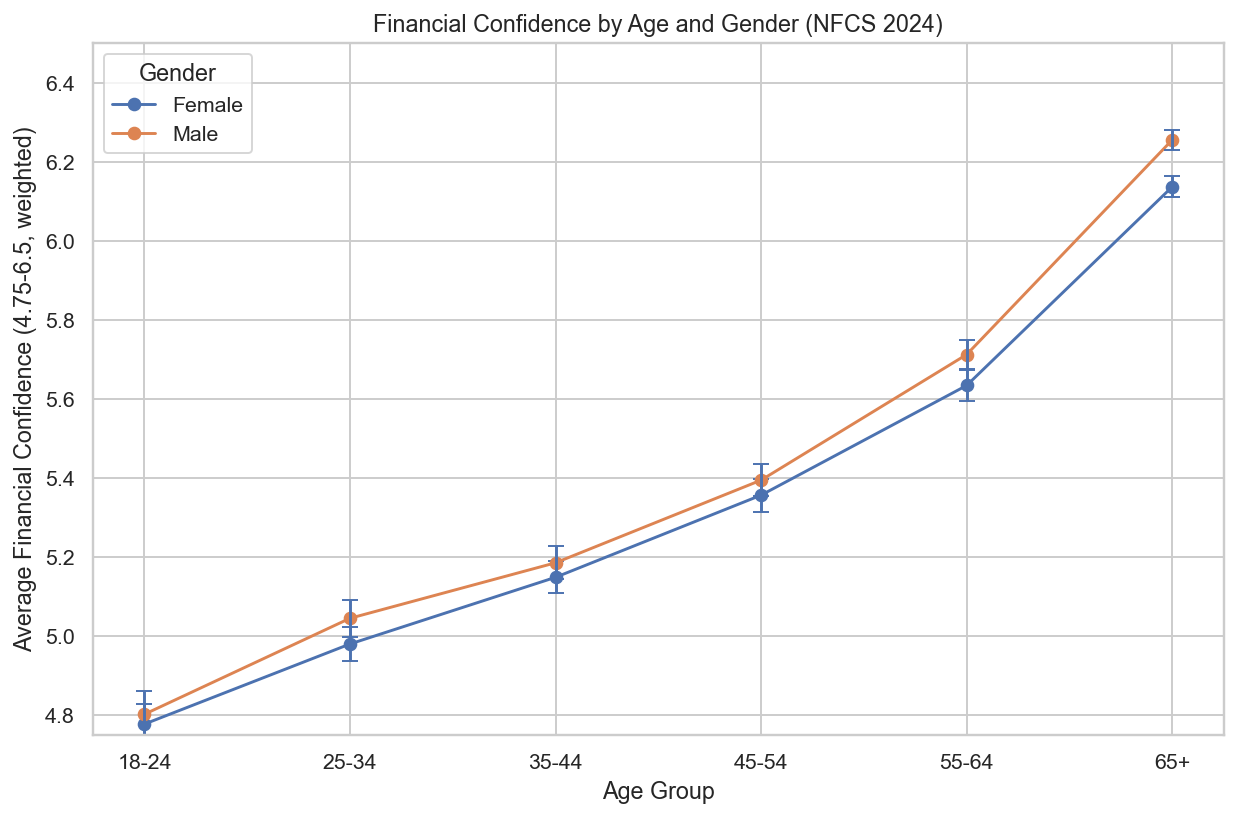

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# How does financial Confidence vary across age groups and genders in the 2024 NFCS data?

# ========= 0) Load & normalize columns =========
df = pd.read_csv("2024 Cleaned.csv")
df.columns = [c.strip().lower() for c in df.columns]

def pick(col_like):
    for c in df.columns:
        if col_like in c:
            return c
    return None

finconf_col = pick("financial confidence")
age_col     = pick("age group")
gender_col  = pick("gender")
weight_col  = pick("wgt_n2")

print("Using columns:", finconf_col, age_col, gender_col, weight_col)

# ========= 1) Coerce weight and map 1–7 scale =========
df[weight_col] = pd.to_numeric(df[weight_col], errors="coerce")

def to_fc_num(s):
    if pd.isna(s): 
        return np.nan
    t = str(s).strip().lower()
    # 2024 format examples:
    # "7 - Strongly Agree", "6", "5", "4 - Neither Agree nor Disagree", "3", "2", "1 - Strongly Disagree"
    if t.startswith("7"): return 7
    if t == "6": return 6
    if t == "5": return 5
    if t.startswith("4"): return 4
    if t == "3": return 3
    if t == "2": return 2
    if t.startswith("1"): return 1
    if "don't know" in t or "dont know" in t or "prefer not" in t:
        return np.nan
    return np.nan

df["finconf_num"] = df[finconf_col].map(to_fc_num)

# ========= 2) Build working frame & diagnostics =========
work = df.dropna(subset=[age_col, gender_col, weight_col, "finconf_num"]).copy()

print("\nDiagnostics:")
print(" - raw value counts (top):")
print(df[finconf_col].value_counts(dropna=False).head(10))
print(" - mapped 1–7 counts:")
print(df["finconf_num"].value_counts(dropna=False).sort_index())
print(" - rows kept for analysis:", len(work))
print(" - age groups:", work[age_col].unique())
print(" - genders:", work[gender_col].unique())
print(" - weight summary:\n", work[weight_col].describe())

if work.empty:
    raise ValueError("No rows remain after cleaning. Check column names and mapping above.")

# ========= 3) Weighted summary =========
def wmean(x, w):
    x, w = np.asarray(x, float), np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(w)
    x, w = x[m], w[m]
    return np.nan if w.sum() == 0 else (w * x).sum() / w.sum()

def wsd(x, w):
    x, w = np.asarray(x, float), np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(w)
    x, w = x[m], w[m]
    if w.sum() == 0: return np.nan
    mu = (w * x).sum() / w.sum()
    return np.sqrt((w * (x - mu) ** 2).sum() / w.sum())

def summarize_age_gender(d):
    out = (
        d.groupby([age_col, gender_col], dropna=False)
         .apply(lambda g: pd.Series({
             "mean_w": wmean(g["finconf_num"], g[weight_col]),
             "sd_w":   wsd(g["finconf_num"], g[weight_col]),
             "w_sum":  g[weight_col].sum(),
             "w2_sum": np.square(g[weight_col]).sum(),
             "n":      g["finconf_num"].notna().sum()
         }))
         .reset_index()
    )
    out["n_eff"] = (out["w_sum"]**2) / out["w2_sum"].replace(0, np.nan)
    out["se_w"]  = out["sd_w"] / np.sqrt(out["n_eff"].clip(lower=1))
    return out

age_gender_tbl = summarize_age_gender(work)

print("\nHead of age×gender table:")
print(age_gender_tbl.head(12))

# ========= 4) Plot interaction (Age × Gender) =========
plt.rcParams["figure.dpi"] = 140
age_order = ["18-24","25-34","35-44","45-54","55-64","65+"]

# If labels match standard, enforce order
if set(age_order).issuperset(set(work[age_col].dropna().unique())):
    age_gender_tbl[age_col] = pd.Categorical(age_gender_tbl[age_col], categories=age_order, ordered=True)

plt.figure(figsize=(9,6))
for g in age_gender_tbl[gender_col].dropna().unique():
    sub = age_gender_tbl[age_gender_tbl[gender_col] == g].sort_values(age_col)
    plt.plot(sub[age_col].astype(str), sub["mean_w"], marker="o", label=str(g))
    plt.errorbar(sub[age_col].astype(str), sub["mean_w"], yerr=sub["se_w"], fmt='none', capsize=4)

plt.xlabel("Age Group")
plt.ylabel("Average Financial Confidence (4.75-6.5, weighted)")
plt.title("Financial Confidence by Age and Gender (NFCS 2024)")
plt.ylim(4.75, 6.5)  # lock to the scale range
plt.legend(title="Gender")
plt.tight_layout()
plt.savefig("finconf_by_age_gender_2024.png")
plt.show()



Financial confidence increases steadily with age in the 2024 NFCS data. Young adults (18–24) report the lowest average confidence, while older adults (65+) display the highest levels, suggesting that confidence grows with financial experience and accumulated decision-making. Across all age groups, men consistently report slightly higher confidence than women, though the gender gap remains modest. These results indicate that both age and gender are significant factors in shaping financial confidence, with generational experience playing a stronger role than gender differences.

/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_1886/9524280.py:77: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_1886/9524280.py:92: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


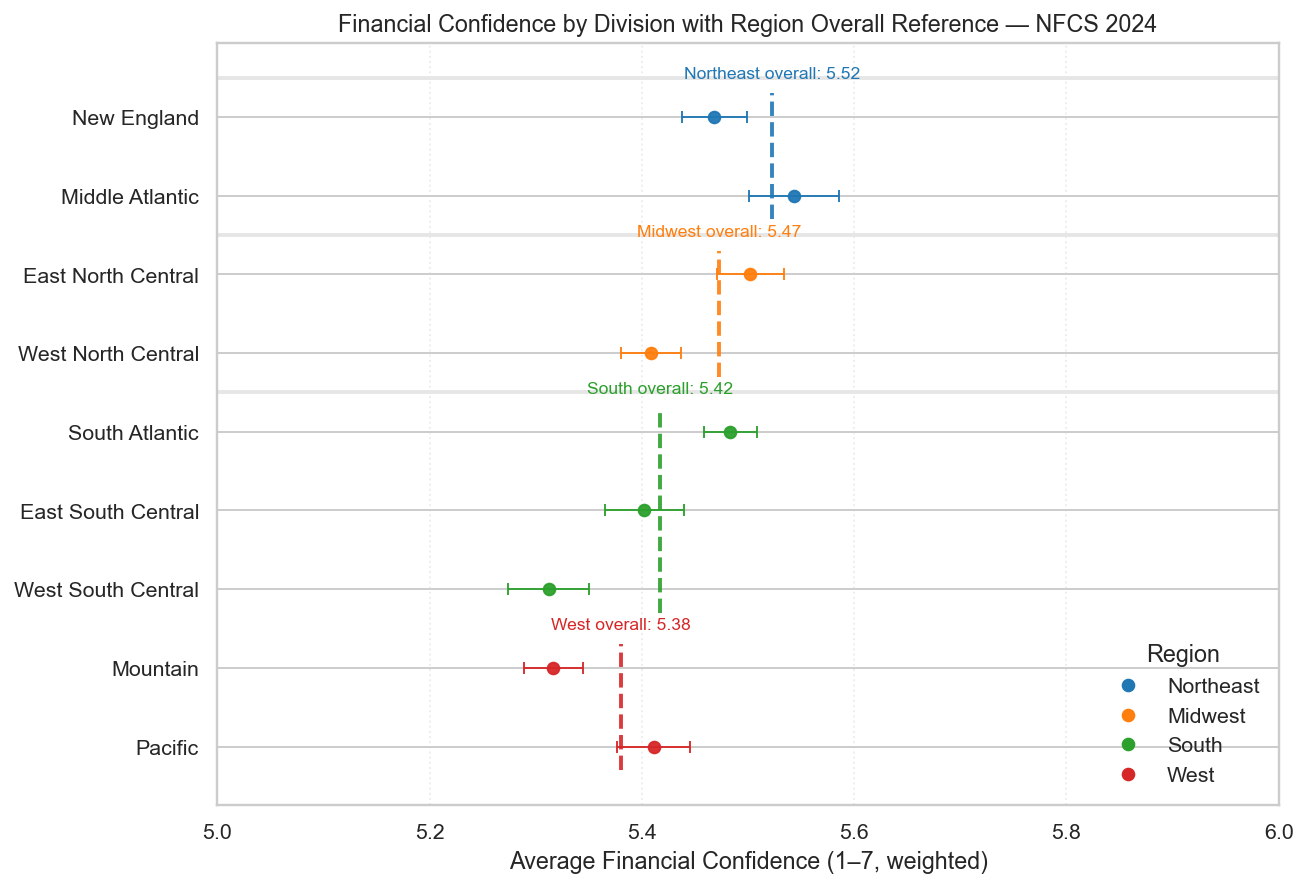

In [46]:
# How does financial confidence vary across regions and divisions in the 2024 NFCS data?
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== 1) Load & normalize columns =====
CSV_PATH = "2024 Cleaned.csv"
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip().lower() for c in df.columns]

def pick(col_like: str):
    for c in df.columns:
        if col_like in c:
            return c
    raise KeyError(f"Column containing '{col_like}' not found. Available: {df.columns.tolist()}")

finconf_col = pick("financial confidence")   # Likert 1–7 in NFCS 2024
region_col  = pick("censusreg")              # Region
division_col= pick("censusdiv")              # Division
weight_col  = pick("wgt_n2")                 # Survey weight

# Coerce weights to numeric
df[weight_col] = pd.to_numeric(df[weight_col], errors="coerce")

# ===== 2) Map Financial Confidence to 1–7 (robust to labels like "7 - Strongly Agree") =====
def to_fc_num(x):
    if pd.isna(x):
        return np.nan
    t = str(x).strip().lower()
    if t.startswith("7"): return 7
    if t == "6":         return 6
    if t == "5":         return 5
    if t.startswith("4"): return 4
    if t == "3":         return 3
    if t == "2":         return 2
    if t.startswith("1"): return 1
    if "don't know" in t or "prefer not" in t:
        return np.nan
    return np.nan

df["finconf_num"] = df[finconf_col].map(to_fc_num)

# Keep rows needed for analysis
work = df.dropna(subset=[region_col, division_col, weight_col, "finconf_num"]).copy()

# ===== 3) Canonical orders (US Census) =====
region_order = ["Northeast", "Midwest", "South", "West"]
division_order_by_region = {
    "Northeast": ["New England", "Middle Atlantic"],
    "Midwest":   ["East North Central", "West North Central"],
    "South":     ["South Atlantic", "East South Central", "West South Central"],
    "West":      ["Mountain", "Pacific"],
}
division_order = sum([division_order_by_region[r] for r in region_order], [])

# ===== 4) Weighted statistics (mean, sd, n_eff, se) =====
def wmean(x, w):
    x = np.asarray(x, float)
    w = np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(w)
    if not m.any() or w[m].sum() == 0:
        return np.nan
    return np.sum(w[m] * x[m]) / np.sum(w[m])

def wsd(x, w):
    x = np.asarray(x, float)
    w = np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(w)
    if not m.any() or w[m].sum() == 0:
        return np.nan
    mu = np.sum(w[m] * x[m]) / np.sum(w[m])
    return np.sqrt(np.sum(w[m] * (x[m] - mu) ** 2) / np.sum(w[m]))

# Region-level stats
reg_stats = (
    work.groupby(region_col, dropna=False)
        .apply(lambda g: pd.Series({
            "mean": wmean(g["finconf_num"], g[weight_col]),
            "sd":   wsd(g["finconf_num"], g[weight_col]),
            "w_sum": g[weight_col].sum(),
            "w2_sum": np.square(g[weight_col]).sum()
        }))
        .reset_index()
)
reg_stats["n_eff"] = (reg_stats["w_sum"] ** 2) / reg_stats["w2_sum"].replace(0, np.nan)
reg_stats["se"] = reg_stats["sd"] / np.sqrt(reg_stats["n_eff"].clip(lower=1))
reg_means = dict(zip(reg_stats[region_col], reg_stats["mean"]))

# Division-level stats
div_stats = (
    work.groupby([division_col, region_col], dropna=False)
        .apply(lambda g: pd.Series({
            "mean": wmean(g["finconf_num"], g[weight_col]),
            "sd":   wsd(g["finconf_num"], g[weight_col]),
            "w_sum": g[weight_col].sum(),
            "w2_sum": np.square(g[weight_col]).sum()
        }))
        .reset_index()
)
div_stats["n_eff"] = (div_stats["w_sum"] ** 2) / div_stats["w2_sum"].replace(0, np.nan)
div_stats["se"] = div_stats["sd"] / np.sqrt(div_stats["n_eff"].clip(lower=1))

# Keep only divisions in canonical order, and keep the defined region
div_stats = div_stats.set_index(division_col).loc[division_order].reset_index()
div_stats = div_stats[div_stats[region_col].isin(region_order)].copy()

# ===== 5) Build plotting frame (Divisions only; no region labels on the left) =====
plot_df = div_stats[[division_col, region_col, "mean", "se"]].copy()
# Reverse for top-to-bottom order (Northeast block at top)
plot_df = plot_df.iloc[::-1].reset_index(drop=True)

# ===== 6) Plot: dot plot with region overall dashed lines, x-axis [5, 6] =====
plt.rcParams["figure.dpi"] = 140
fig, ax = plt.subplots(figsize=(9.5, 6.5))

colors = {"Northeast": "#1f77b4", "Midwest": "#ff7f0e", "South": "#2ca02c", "West": "#d62728"}

y = np.arange(len(plot_df))
for i, row in plot_df.iterrows():
    ax.errorbar(row["mean"], y[i], xerr=row["se"], fmt="o", capsize=3, lw=1,
                color=colors.get(row[region_col], "black"),
                ecolor=colors.get(row[region_col], "black"), alpha=0.95)

# Region overall reference lines and labels
for reg in region_order:
    if reg in reg_means and np.isfinite(reg_means[reg]):
        mean_val = reg_means[reg]
        # y-range spanned by this region's divisions
        idxs = plot_df.index[plot_df[region_col] == reg]
        if len(idxs) > 0:
            y0, y1 = idxs.min(), idxs.max()
            ax.vlines(mean_val, y0 - 0.3, y1 + 0.3,
                      color=colors[reg], ls="--", lw=2, alpha=0.9)
            ax.text(mean_val, y1 + 0.45, f"{reg} overall: {mean_val:.2f}",
                    ha="center", va="bottom", fontsize=9, color=colors[reg])

# Cosmetics
ax.set_yticks(y)
ax.set_yticklabels(plot_df[division_col])
ax.set_xlim(5, 6)  # << focus range 5–6
ax.set_xlabel("Average Financial Confidence (1–7, weighted)")
ax.set_title("Financial Confidence by Division with Region Overall Reference — NFCS 2024")
ax.grid(axis="x", linestyle=":", alpha=0.35)

# Optional: light separators between region blocks
region_breaks = []
for reg in region_order:
    idxs = plot_df.index[plot_df[region_col] == reg]
    if len(idxs) > 0:
        region_breaks.append(idxs.max())
for b in region_breaks[:-1]:  # skip the last one
    ax.hlines(b + 0.5, 5, 6, colors="#e6e6e6", lw=2)

# Legend
from matplotlib.lines import Line2D
legend_items = [Line2D([0], [0], marker='o', color='w', label=r,
                       markerfacecolor=c, markeredgecolor=c)
                for r, c in colors.items()]
ax.legend(handles=legend_items, title="Region", loc="lower right", frameon=False)

plt.tight_layout()
plt.savefig("finconf_division_dotplot_2024.png", dpi=300) 
plt.show()


Financial confidence in the 2024 NFCS shows modest but consistent variation across U.S. regions and divisions. Respondents in the Northeast report the highest overall confidence (5.52), followed closely by the Midwest (5.47). The South (5.42) and West (5.38) trail slightly behind. Within each region, most divisions align closely with the regional average, though small deviations exist: for example, the Middle Atlantic slightly outperforms the New England division in the Northeast, while in the South, the South Atlantic scores higher than the West South Central. These findings suggest that while regional differences are relatively narrow, local economic and cultural contexts at the division level may contribute to subtle variations in financial confidence.

/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_1886/2040096793.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  work.groupby([division_col, age_col, gender_col], dropna=False)
/var/folders/jz/k_vbt06j575b45vdglnjz_680000gn/T/ipykernel_1886/2040096793.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: wmean(g["finconf_num"], g[weight_col]))


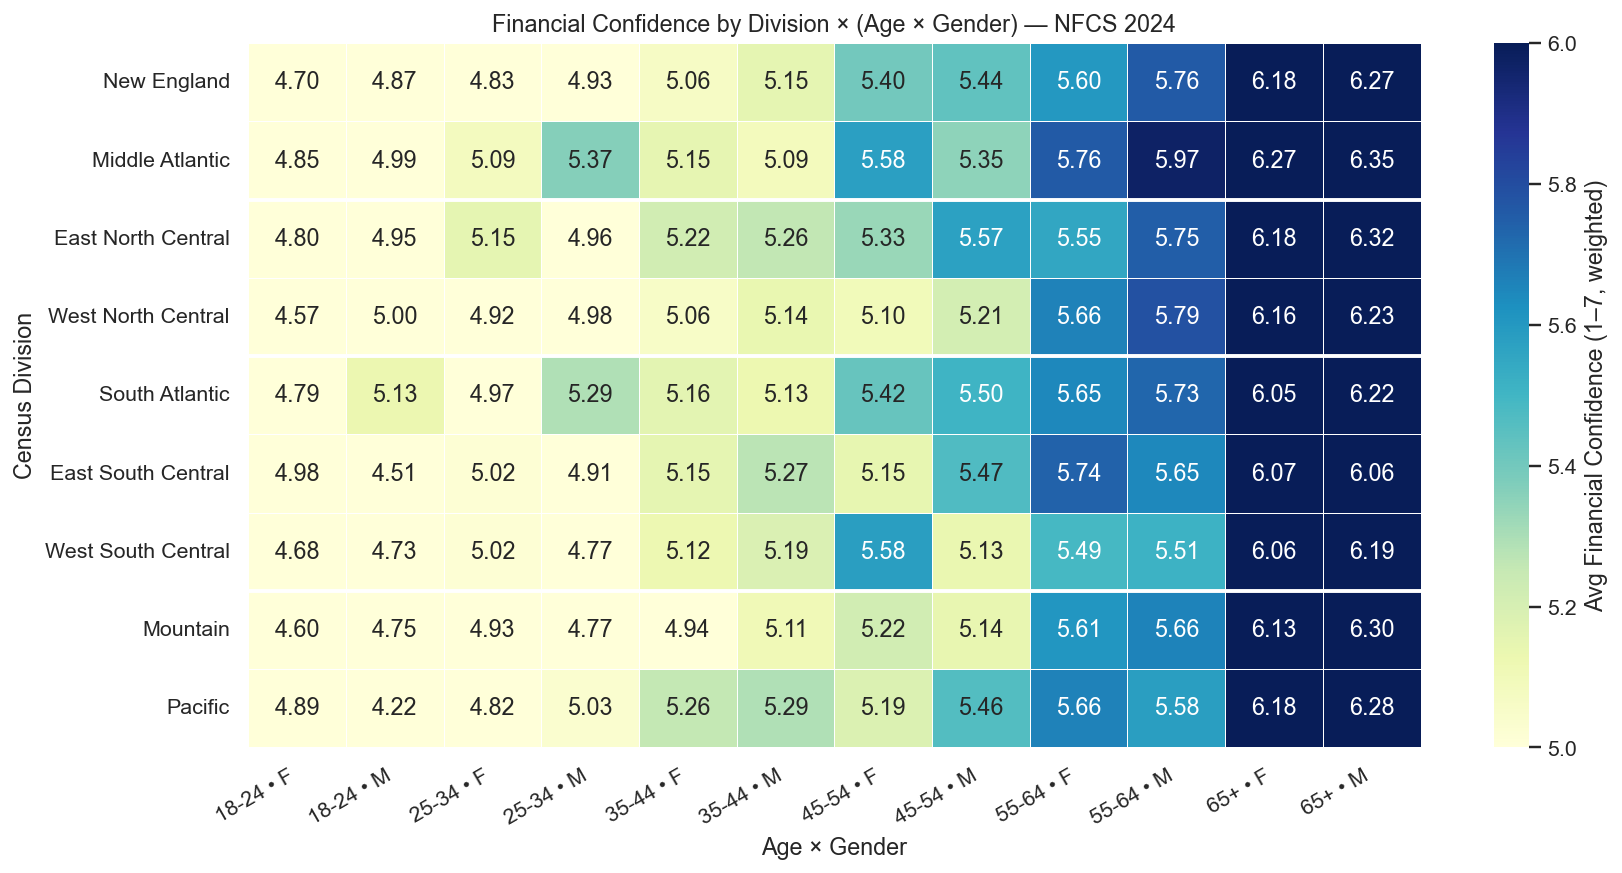

In [47]:
#How does financial confidence vary across census divisions, age groups, and genders in the 2024 NFCS data?

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1) Load & normalize =====
CSV_PATH = "2024 Cleaned.csv"
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip().lower() for c in df.columns]

def pick(col_like: str):
    for c in df.columns:
        if col_like in c:
            return c
    raise KeyError(f"Column containing '{col_like}' not found. Available: {df.columns.tolist()}")

finconf_col = pick("financial confidence")
division_col= pick("censusdiv")
region_col  = pick("censusreg")
age_col     = pick("age group")
gender_col  = pick("gender")
weight_col  = pick("wgt_n2")

df[weight_col] = pd.to_numeric(df[weight_col], errors="coerce")

# Map Financial Confidence to 1–7 (robust to label variants like "7 - Strongly Agree")
def to_fc_num(x):
    if pd.isna(x): return np.nan
    t = str(x).strip().lower()
    if t.startswith("7"): return 7
    if t == "6": return 6
    if t == "5": return 5
    if t.startswith("4"): return 4
    if t == "3": return 3
    if t == "2": return 2
    if t.startswith("1"): return 1
    if "don't know" in t or "prefer not" in t: return np.nan
    return np.nan

df["finconf_num"] = df[finconf_col].map(to_fc_num)

# Keep rows needed for analysis
work = df.dropna(subset=[division_col, region_col, age_col, gender_col, weight_col, "finconf_num"]).copy()

# ===== 2) Canonical orders =====
region_order = ["Northeast","Midwest","South","West"]
division_order_by_region = {
    "Northeast": ["New England","Middle Atlantic"],
    "Midwest":   ["East North Central","West North Central"],
    "South":     ["South Atlantic","East South Central","West South Central"],
    "West":      ["Mountain","Pacific"],
}
division_order = sum([division_order_by_region[r] for r in region_order], [])

age_order    = ["18-24","25-34","35-44","45-54","55-64","65+"]
gender_order = ["Female","Male"]

work[division_col] = pd.Categorical(work[division_col], division_order, ordered=True)
work[region_col]   = pd.Categorical(work[region_col],   region_order,   ordered=True)
work[age_col]      = pd.Categorical(work[age_col],      age_order,      ordered=True)
work[gender_col]   = pd.Categorical(work[gender_col],   gender_order,   ordered=True)

# ===== 3) Weighted mean helper =====
def wmean(x, w):
    x = np.asarray(x, float); w = np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(w)
    if not m.any() or w[m].sum() == 0: return np.nan
    return np.sum(w[m]*x[m]) / np.sum(w[m])

# ===== 4) Aggregate: Division × Age × Gender (weighted mean) =====
agg = (
    work.groupby([division_col, age_col, gender_col], dropna=False)
        .apply(lambda g: wmean(g["finconf_num"], g[weight_col]))
        .reset_index(name="mean_w")
)

# --- Safe string labels (avoid categorical + op) ---
short_map = {"Female": "F", "Male": "M"}
agg["age_str"] = agg[age_col].astype(str)
agg["g_str"]   = agg[gender_col].astype(str).map(short_map).fillna(
    agg[gender_col].astype(str).str[0].str.upper()
)
agg["col_label"] = agg["age_str"].str.cat(agg["g_str"], sep=" • ")

# Desired column order: Age1 F, Age1 M, Age2 F, Age2 M, ...
col_order = []
for a in age_order:
    for g in gender_order:
        col_order.append(f"{a} • {short_map.get(g,'?')}")

# Pivot to a 9 × 12 matrix (Divisions × Age×Gender)
mat = agg.pivot(index=division_col, columns="col_label", values="mean_w")
mat = mat.reindex(index=division_order, columns=col_order)

# ===== 5) Plot heatmap =====
plt.rcParams["figure.dpi"] = 140
fig, ax = plt.subplots(figsize=(12.5, 6.4))

sns.heatmap(
    mat, annot=True, fmt=".2f",
    cmap="YlGnBu",
    vmin=5, vmax=6,                         # zoom range; use (4,7) for full scale
    linewidths=0.5, linecolor="white",
    cbar_kws={"label": "Avg Financial Confidence (1–7, weighted)"},
    ax=ax
)

ax.set_title("Financial Confidence by Division × (Age × Gender) — NFCS 2024")
ax.set_xlabel("Age × Gender")
ax.set_ylabel("Census Division")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Optional: draw horizontal separators between region blocks for readability
split_after = [
    len(division_order_by_region["Northeast"]),
    len(division_order_by_region["Northeast"]) + len(division_order_by_region["Midwest"]),
    len(division_order_by_region["Northeast"]) + len(division_order_by_region["Midwest"]) + len(division_order_by_region["South"]),
]
for y in split_after:
    ax.hlines(y, *ax.get_xlim(), colors="white", linewidth=2)

plt.tight_layout()
plt.savefig("finconf_heatmap_division_age_gender_2024.png", dpi=300)
plt.show()



The heatmap highlights how financial confidence varies simultaneously by division, age, and gender in the 2024 NFCS. Across nearly all divisions, confidence is lowest among young adults (18–24) and rises steadily with age, peaking among those 65 and older. Men generally report slightly higher confidence than women in the same age group, but the gender gap is modest compared to the much larger age effect. At the geographic level, divisions such as the Middle Atlantic, East North Central, and Pacific show relatively higher confidence across most age–gender groups, while West South Central and Mountain tend to lag slightly behind. This pattern suggests that while regional context plays a role, the progression of financial confidence across the life cycle is the most dominant factor, with gender differences remaining consistent but secondary.